Download/Load SP500 stocks prices data

In [63]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-03-24'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-03-28 A        37.037910   39.520000   39.750000   39.139999   39.540001   
           AAL      39.202137   40.910000   41.340000   40.330002   41.000000   
           AAPL     24.040298   26.297501   26.547501   26.264999   26.500000   
           ABBV     39.753647   56.110001   56.700001   55.799999   56.349998   
           ABT      35.243382   40.880001   41.000000   40.610001   40.770000   
...                       ...         ...         ...         ...         ...   
2024-03-22 XYL     129.210007  129.210007  130.479996  128.770004  129.929993   
           YUM     136.229996  136.229996  136.720001  135.649994  136.610001   
           ZBH     127.199997  127.199997  127.650002  125.879997  127.269997   
           ZBRA    291.440002  291.440002  293.869995  290.160004  293.869995   
           ZTS     168.899994  168.899994  171.360001  168.160004  168.770004   

Price                  volume  
date       ticker              
2016-03-28 A        1272700.0  
           AAL      6402800.0  
           AAPL    77645600.0  
           ABBV     3803100.0  
           ABT      3328000.0  
...                       ...  
2024-03-22 XYL       732400.0  
           YUM      1296400.0  
           ZBH      1419200.0  
           ZBRA      201800.0  
           ZTS      2840500.0  

[995648 rows x 6 columns]

Calculate features and technical indicators for each stock.

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [64]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

#df

In [65]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
    low=stock_data['low'],
    close=stock_data['close'],
    length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-03-28 A        37.037910   39.520000   39.750000   39.139999   39.540001   
           AAL      39.202137   40.910000   41.340000   40.330002   41.000000   
           AAPL     24.040298   26.297501   26.547501   26.264999   26.500000   
           ABBV     39.753647   56.110001   56.700001   55.799999   56.349998   
           ABT      35.243382   40.880001   41.000000   40.610001   40.770000   
...                       ...         ...         ...         ...         ...   
2024-03-22 XYL     129.210007  129.210007  130.479996  128.770004  129.929993   
           YUM     136.229996  136.229996  136.720001  135.649994  136.610001   
           ZBH     127.199997  127.199997  127.650002  125.879997  127.269997   
           ZBRA    291.440002  291.440002  293.869995  290.160004  293.869995   
           ZTS     168.899994  168.899994  171.360001  168.160004  168.770004   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-03-28 A        1272700.0         -0.001531        NaN       NaN   
           AAL      6402800.0         -0.000471        NaN       NaN   
           AAPL    77645600.0         -0.003608        NaN       NaN   
           ABBV     3803100.0         -0.046891        NaN       NaN   
           ABT      3328000.0         -0.008151        NaN       NaN   
...                       ...               ...        ...       ...   
2024-03-22 XYL       732400.0          0.000075  66.372960  4.836604   
           YUM      1296400.0          0.000028  52.736484  4.915549   
           ZBH      1419200.0          0.000097  55.330244  4.826682   
           ZBRA      201800.0          0.000054  59.824982  5.616619   
           ZTS      2840500.0          0.000177  33.482479  5.098090   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-03-28 A            NaN       NaN       NaN       NaN      47.138149  
           AAL          NaN       NaN       NaN       NaN     251.003443  
           AAPL         NaN       NaN       NaN       NaN    1866.623398  
           ABBV         NaN       NaN       NaN       NaN     151.187094  
           ABT          NaN       NaN       NaN       NaN     117.289974  
...                     ...       ...       ...       ...            ...  
2024-03-22 XYL     4.855185  4.873767 -0.170416  1.071474      94.633409  
           YUM     4.935263  4.954977 -0.008496  0.328832     176.608566  
           ZBH     4.845375  4.864068 -0.736258  0.191079     180.522236  
           ZBRA    5.654357  5.692095  0.007843  0.700949      58.812592  
           ZTS     5.209244  5.320399  1.034330 -2.790276     479.760433  

[995648 rows x 14 columns]

Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [66]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')],
    axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-05-31 A          104.726089   43.132317         -0.001339  75.768854   
           AAL        304.649001   30.666254         -0.000261  32.678150   
           AAPL      3737.581293   22.961115         -0.002413  52.874800   
           ABBV       431.810200   45.014004         -0.042372  61.528125   
           ABT        398.829151   34.374458         -0.006916  50.522117   
...                          ...         ...               ...        ...   
2024-03-31 XYL        123.836174  129.210007          0.000075  66.372960   
           YUM        297.000504  136.229996          0.000028  52.736484   
           ZBH        149.491883  127.199997          0.000097  55.330244   
           ZBRA        91.815006  291.440002          0.000054  59.824982   
           ZTS        741.177311  168.899994          0.000177  33.482479   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-05-31 A       3.653723  3.732657  3.811592 -1.296093  0.465468  
           AAL     3.423399  3.470762  3.518124 -0.117002 -1.587071  
           AAPL    3.067553  3.128054  3.188554 -1.138819 -0.341559  
           ABBV    3.767178  3.809104  3.851030 -1.091049 -0.076839  
           ABT     3.498909  3.529178  3.559447 -1.206110 -0.630059  
...                     ...       ...       ...       ...       ...  
2024-03-31 XYL     4.836604  4.855185  4.873767 -0.170416  1.071474  
           YUM     4.915549  4.935263  4.954977 -0.008496  0.328832  
           ZBH     4.826682  4.845375  4.864068 -0.736258  0.191079  
           ZBRA    5.616619  5.654357  5.692095  0.007843  0.700949  
           ZTS     5.098090  5.209244  5.320399  1.034330 -2.790276  

[47013 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks

In [67]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-04-30 AAL      41.276722         -0.001000  45.213602  3.691857   
           AAPL     33.524036         -0.001970  61.191621  3.520674   
           ABBV     48.986916         -0.034448  63.760429  3.870198   
           ABT      38.811470         -0.005357  48.977544  3.668610   
           ACN     109.622169         -0.003212  58.138687  4.644193   
...                       ...               ...        ...       ...   
2024-03-31 VRTX    415.660004          0.000080  49.139745  5.999202   
           VZ       40.369999          0.000164  53.261889  3.699675   
           WFC      57.130001          0.000068  65.780531  4.014071   
           WMT      60.869999          0.000041  65.870457  4.084939   
           XOM     113.489998          0.000030  71.448332  4.633631   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-04-30 AAL     3.766755  3.841652  0.800192  0.661181  
           AAPL    3.536714  3.552755 -1.225953 -0.161239  
           ABBV    3.889972  3.909746 -1.428387 -0.122822  
           ABT     3.683933  3.699257 -1.337362 -0.302409  
           ACN     4.674263  4.704333 -1.138129 -0.204717  
...                     ...       ...       ...       ...  
2024-03-31 VRTX    6.036142  6.073082  0.790102 -0.938697  
           VZ      3.713888  3.728101 -0.628603 -0.048811  
           WFC     4.053640  4.093210 -0.160137  1.662901  
           WMT     4.114263  4.143587  0.268979  1.982052  
           XOM     4.695649  4.757667 -0.085597  2.128755  

[12516 rows x 8 columns]

Calculate Monthly Returns for different time horizons as features.

In [68]:
g = df.xs('AAPL', level=1)
g.head()

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2016-03-28,24.040298,26.297501,26.547501,26.264999,26.5000,77645600.0,-0.003608,NaN,NaN,NaN,NaN,NaN,NaN,1866.623398
2016-03-29,24.609364,26.920000,26.947500,26.219999,26.2225,124760400.0,-0.001183,NaN,NaN,NaN,NaN,NaN,NaN,3070.274041
2016-03-30,25.039019,27.389999,27.605000,27.150000,27.1625,182404400.0,-0.002422,NaN,NaN,NaN,NaN,NaN,NaN,4567.227170
2016-03-31,24.908752,27.247499,27.475000,27.219999,27.4300,103553600.0,-0.003548,NaN,NaN,NaN,NaN,NaN,NaN,2579.390987
2016-04-01,25.137293,27.497499,27.500000,27.049999,27.1950,103496000.0,-0.002255,NaN,NaN,NaN,NaN,NaN,NaN,2601.609262


In [69]:
outlier_cutoff = 0.005

lags = [1, 2, 3, 6, 9, 12]

for lag in lags:

    df[f'return_{lag}m'] = (df['adj close']
        .pct_change(lag)
        .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                upper=x.quantile(1-outlier_cutoff)))
        .add(1)
        .pow(1/lag)
        .sub(1))
    
g

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2016-03-28,24.040298,26.297501,26.547501,26.264999,26.500000,77645600.0,-0.003608,NaN,NaN,NaN,NaN,NaN,NaN,1866.623398
2016-03-29,24.609364,26.920000,26.947500,26.219999,26.222500,124760400.0,-0.001183,NaN,NaN,NaN,NaN,NaN,NaN,3070.274041
2016-03-30,25.039019,27.389999,27.605000,27.150000,27.162500,182404400.0,-0.002422,NaN,NaN,NaN,NaN,NaN,NaN,4567.227170
2016-03-31,24.908752,27.247499,27.475000,27.219999,27.430000,103553600.0,-0.003548,NaN,NaN,NaN,NaN,NaN,NaN,2579.390987
2016-04-01,25.137293,27.497499,27.500000,27.049999,27.195000,103496000.0,-0.002255,NaN,NaN,NaN,NaN,NaN,NaN,2601.609262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,173.720001,173.720001,177.710007,173.520004,175.570007,75604200.0,0.000241,40.000069,5.118886,5.177668,5.236449,0.772731,-1.979356,13133.961716
2024-03-19,176.080002,176.080002,176.610001,173.029999,174.339996,55215200.0,0.000172,44.428829,5.118932,5.176144,5.233356,0.781405,-1.766397,9722.292517
2024-03-20,178.669998,178.669998,178.669998,175.089996,175.720001,53423100.0,0.000098,48.795061,5.119751,5.175138,5.230526,0.789461,-1.481159,9545.105179


In [70]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
            .pct_change(lag)
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                upper=x.quantile(1-outlier_cutoff)))
            .add(1)
            .pow(1/lag)
            .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-04-30 AAL      41.922886         -0.000233  34.064586  3.733074   
           AAPL     39.177334          0.000096  44.093131  3.663645   
           ABBV     74.159782         -0.031916  47.693763  4.229163   
           ABT      52.741093         -0.005614  45.310102  3.974422   
           ACN     139.184555         -0.003448  47.986180  4.908076   
...                       ...               ...        ...       ...   
2024-03-31 VRTX    415.660004          0.000080  49.139745  5.999202   
           VZ       40.369999          0.000164  53.261889  3.699675   
           WFC      57.130001          0.000068  65.780531  4.014071   
           WMT      60.869999          0.000041  65.870457  4.084939   
           XOM     113.489998          0.000030  71.448332  4.633631   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-04-30 AAL     3.847312  3.961549  2.137595 -2.451390  -0.173788   
           AAPL    3.720439  3.777232 -0.813089 -0.522707  -0.015020   
           ABBV    4.280136  4.331109  0.985021 -0.928229   0.030640   
           ABT     3.996780  4.019137 -0.560463 -0.424350  -0.025203   
           ACN     4.940539  4.973001 -0.511388 -0.334872  -0.006292   
...                     ...       ...       ...       ...        ...   
2024-03-31 VRTX    6.036142  6.073082  0.790102 -0.938697  -0.012074   
           VZ      3.713888  3.728101 -0.628603 -0.048811   0.008746   
           WFC     4.053640  4.093210 -0.160137  1.662901   0.027703   
           WMT     4.114263  4.143587  0.268979  1.982052   0.042097   
           XOM     4.695649  4.757667 -0.085597  2.128755   0.085821   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-04-30 AAL     -0.110429  -0.074851  -0.013677  -0.017083    0.001295  
           AAPL    -0.036776  -0.002988  -0.002490   0.013081    0.013071  
           ABBV    -0.082295  -0.045625   0.014256   0.039338    0.035160  
           ABT     -0.016043  -0.020529   0.013257   0.020388    0.025886  
           ACN     -0.026676  -0.017233   0.011571   0.020044    0.020096  
...                      ...        ...        ...        ...         ...  
2024-03-31 VRTX    -0.020657   0.007134   0.030182   0.018671    0.023358  
           VZ      -0.023656   0.028790   0.043844   0.015410    0.009154  
           WFC      0.070747   0.053386   0.060254   0.035650    0.038701  
           WMT      0.053004   0.051403   0.023561   0.018007    0.019208  
           XOM      0.055528   0.046375  -0.002838   0.009273    0.005807  

[10359 rows x 14 columns]

Download Fama-French Factors and Calculate Rolling Factor Betas

In [71]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
        'famafrench',
        start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173788
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.065104
           VZ      0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.128136
           WFC     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.019504
           WMT     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.048208
           XOM     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.028306

[10073 rows x 6 columns]

In [72]:
factor_data.xs('AAPL', level=1)

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-04-30,0.0028,0.0093,0.0054,-0.0242,0.0130,-0.015020
2018-05-31,0.0265,0.0473,-0.0320,-0.0204,-0.0150,0.135124
2018-06-30,0.0048,0.0080,-0.0234,0.0079,0.0024,-0.009418
2018-07-31,0.0319,-0.0193,0.0047,0.0156,0.0035,0.027983
2018-08-31,0.0344,0.0064,-0.0394,-0.0031,-0.0270,0.200422
...,...,...,...,...,...,...
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083,-0.088678
2023-10-31,-0.0319,-0.0404,0.0019,0.0246,-0.0066,-0.002570
2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.113780


In [73]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-04-30,0.0028,0.0093,0.0054,-0.0242,0.0130,0.024652
2018-05-31,0.0265,0.0473,-0.0320,-0.0204,-0.0150,0.061467
2018-06-30,0.0048,0.0080,-0.0234,0.0079,0.0024,-0.002327
2018-07-31,0.0319,-0.0193,0.0047,0.0156,0.0035,0.075753
2018-08-31,0.0344,0.0064,-0.0394,-0.0031,-0.0270,0.062993


Filter out stocks with less than 10 months of data

In [74]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173788
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025203
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.065104
           VZ      0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.128136
           WFC     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.019504
           WMT     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.048208
           XOM     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.028306

[10039 rows x 6 columns]

Calculate Rolling Factor Betas

In [75]:
betas = (factor_data.groupby(level=1,
                     group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
            exog=sm.add_constant(x.drop('return_1m', axis=1)),
            window=min(24, x.shape[0]),
            min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-04-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-01-31 VRTX    0.415344  0.396729 -0.849131  0.199172  1.002521
           VZ      0.480825 -1.086516  0.679389 -0.030914 -0.342825
           WFC     1.079384  0.333311  1.642211 -0.209465 -1.317926
           WMT     0.542134  0.233796 -0.912353  0.669353  0.889302
           XOM     0.785140  0.059119  0.444969  0.817026  0.642083

[10039 rows x 5 columns]

Join the rolling factors data to the main features dataframe.

In [76]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10196 entries, (Timestamp('2018-04-30 00:00:00'), 'AAL') to (Timestamp('2024-03-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10196 non-null  float64
 1   rsi               10196 non-null  float64
 2   bb_low            10196 non-null  float64
 3   bb_mid            10196 non-null  float64
 4   bb_high           10196 non-null  float64
 5   atr               10196 non-null  float64
 6   macd              10196 non-null  float64
 7   return_1m         10196 non-null  float64
 8   return_2m         10196 non-null  float64
 9   return_3m         10196 non-null  float64
 10  return_6m         10196 non-null  float64
 11  return_9m         10196 non-null  float64
 12  return_12m        10196 non-null  float64
 13  Mkt-RF            10196 non-null  float64
 14  SMB               10196 non-null  float64
 15  HML        

K-Means Clustering Algorithm to group similar assets based on their features.

In [83]:
from sklearn.cluster import KMeans

# Check if 'cluster' column exists before dropping it
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

def get_clusters(df):
    try:
        kmeans = KMeans(n_clusters=4, random_state=0)
        df['cluster'] = kmeans.fit(df).labels_
    except Exception as e:
        print("Error occurred during clustering:", e)
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-04-30 AAL            -0.000233  34.064586  3.733074  3.847312  3.961549   
           AAPL            0.000096  44.093131  3.663645  3.720439  3.777232   
           ABBV           -0.031916  47.693763  4.229163  4.280136  4.331109   
           ABT            -0.005614  45.310102  3.974422  3.996780  4.019137   
           ACN            -0.003448  47.986180  4.908076  4.940539  4.973001   
...                             ...        ...       ...       ...       ...   
2024-03-31 VRTX            0.000080  49.139745  5.999202  6.036142  6.073082   
           VZ              0.000164  53.261889  3.699675  3.713888  3.728101   
           WFC             0.000068  65.780531  4.014071  4.053640  4.093210   
           WMT             0.000041  65.870457  4.084939  4.114263  4.143587   
           XOM             0.000030  71.448332  4.633631  4.695649  4.757667   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-04-30 AAL     2.137595 -2.451390  -0.173788  -0.110429  -0.074851   
           AAPL   -0.813089 -0.522707  -0.015020  -0.036776  -0.002988   
           ABBV    0.985021 -0.928229   0.030640  -0.082295  -0.045625   
           ABT    -0.560463 -0.424350  -0.025203  -0.016043  -0.020529   
           ACN    -0.511388 -0.334872  -0.006292  -0.026676  -0.017233   
...                     ...       ...        ...        ...        ...   
2024-03-31 VRTX    0.790102 -0.938697  -0.012074  -0.020657   0.007134   
           VZ     -0.628603 -0.048811   0.008746  -0.023656   0.028790   
           WFC    -0.160137  1.662901   0.027703   0.070747   0.053386   
           WMT     0.268979  1.982052   0.042097   0.053004   0.051403   
           XOM    -0.085597  2.128755   0.085821   0.055528   0.046375   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 AAL     -0.013677  -0.017083    0.001295  1.229975  1.422073   
           AAPL    -0.002490   0.013081    0.013071  1.324507 -0.372436   
           ABBV     0.014256   0.039338    0.035160  0.459422  0.564107   
           ABT      0.013257   0.020388    0.025886  0.808772 -0.142658   
           ACN      0.011571   0.020044    0.020096  1.222612 -0.167936   
...                      ...        ...         ...       ...       ...   
2024-03-31 VRTX     0.030182   0.018671    0.023358  0.530616 -0.039519   
           VZ       0.043844   0.015410    0.009154  0.474318 -0.383777   
           WFC      0.060254   0.035650    0.038701  1.066370 -0.087504   
           WMT      0.023561   0.018007    0.019208  0.603399 -0.427965   
           XOM     -0.002838   0.009273    0.005807  1.106256  0.214597   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 AAL     0.500348  0.150786  0.798802        1  
           AAPL   -0.621839  0.472814  0.633039        3  
           ABBV   -0.169009  0.525229  0.371921        3  
           ABT    -0.493206  0.283110  0.977182        3  
           ACN    -0.288379  0.325815  0.152787        3  
...                     ...       ...       ...      ...  
2024-03-31 VRTX   -0.899744  0.092064  0.811143        3  
           VZ      0.151518  0.260616  0.344449        3  
           WFC     1.534362 -0.754939 -0.759971        0  
           WMT    -0.339817  0.266177  0.686158        0  
           XOM     0.784956 -0.500712  0.521593        2  

[10196 rows x 19 columns]

In [84]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

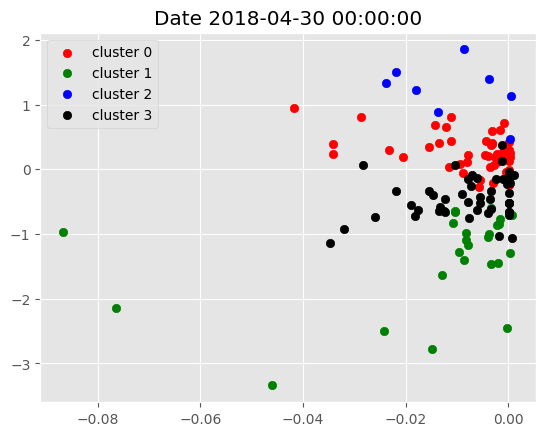

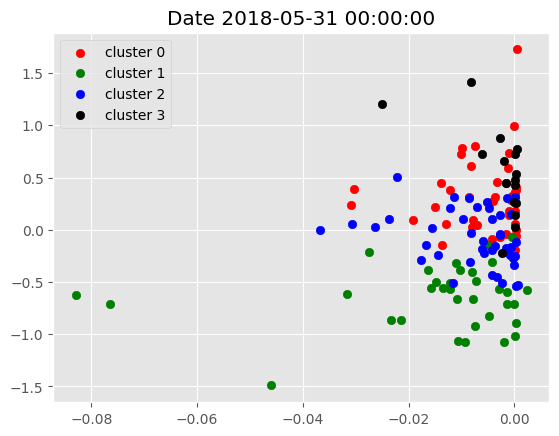

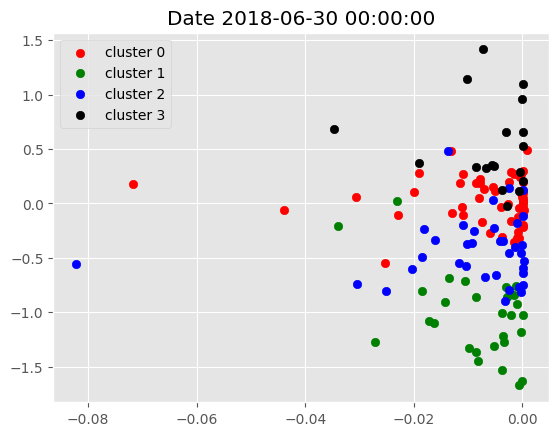

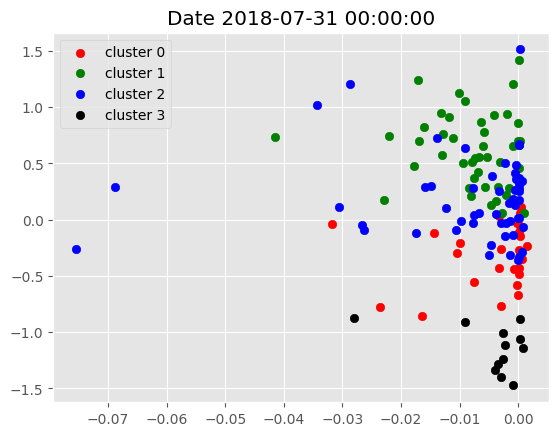

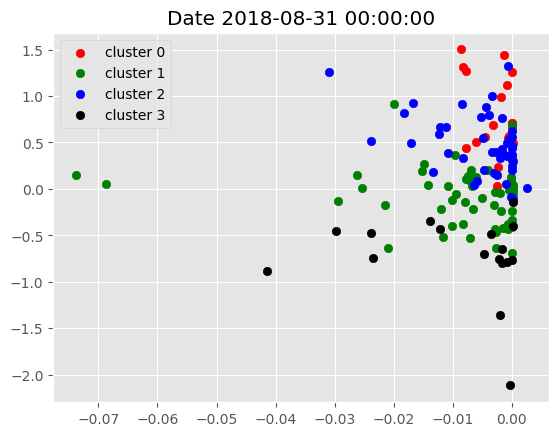

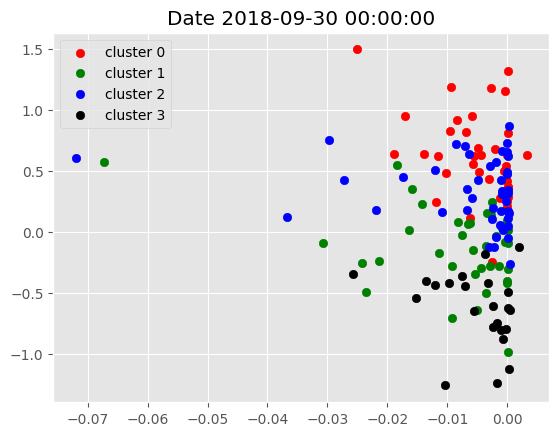

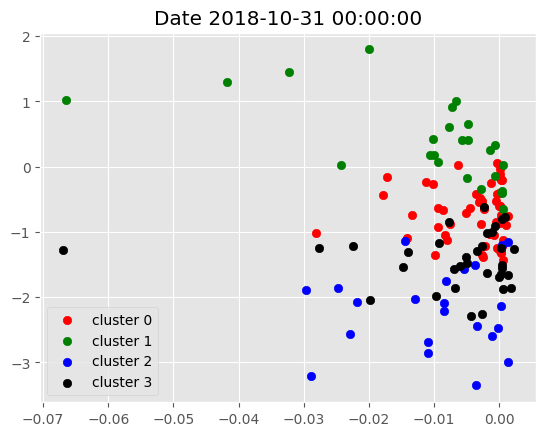

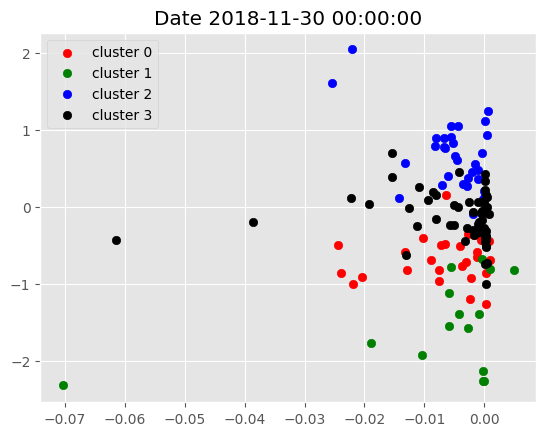

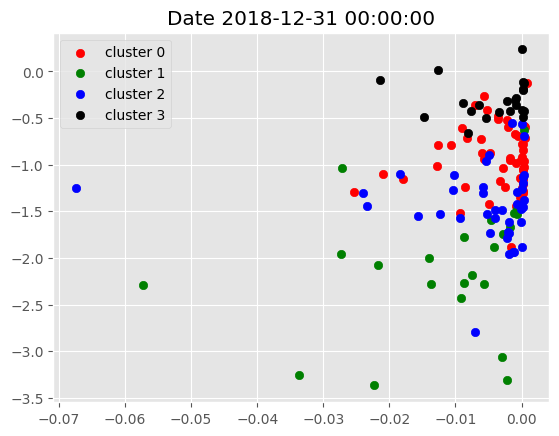

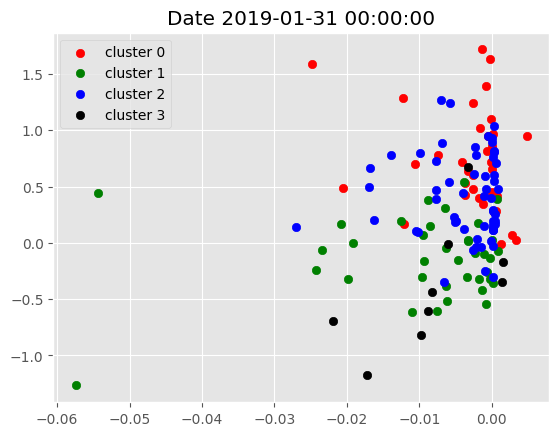

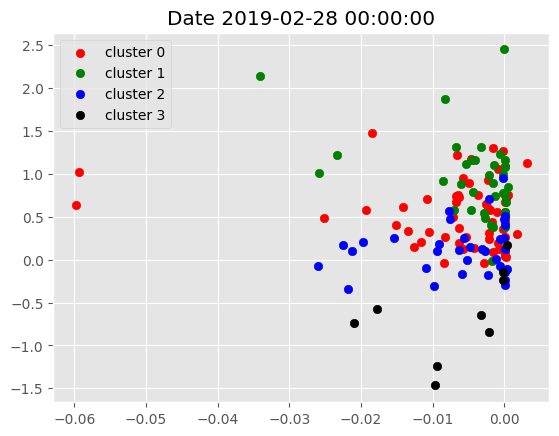

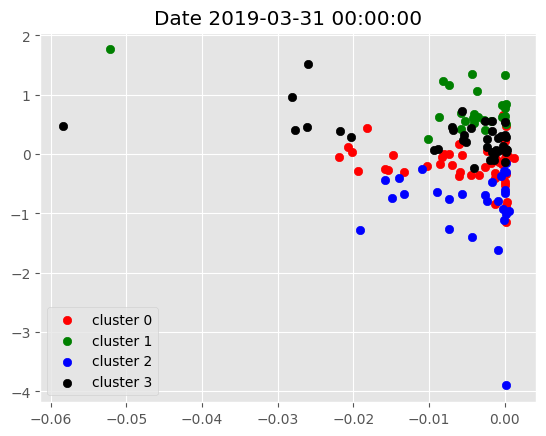

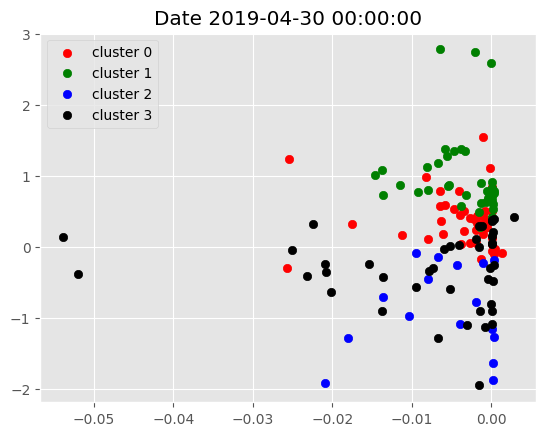

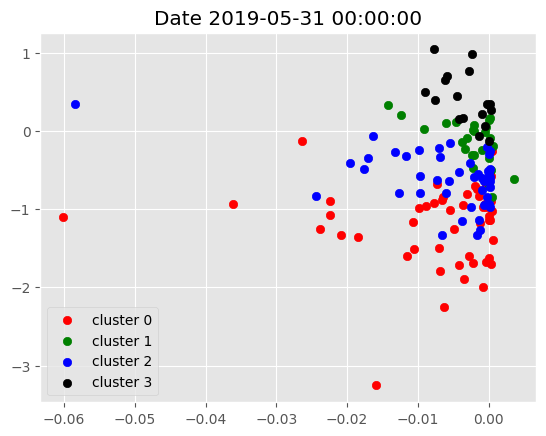

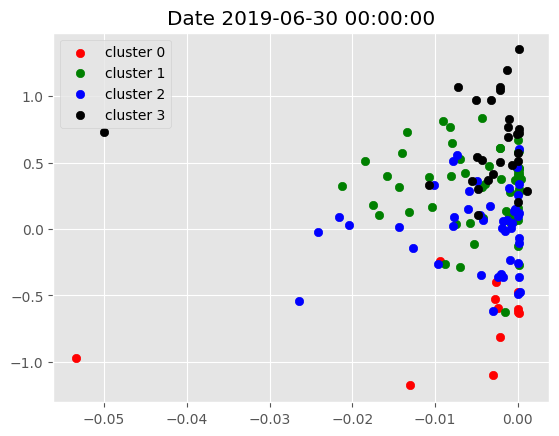

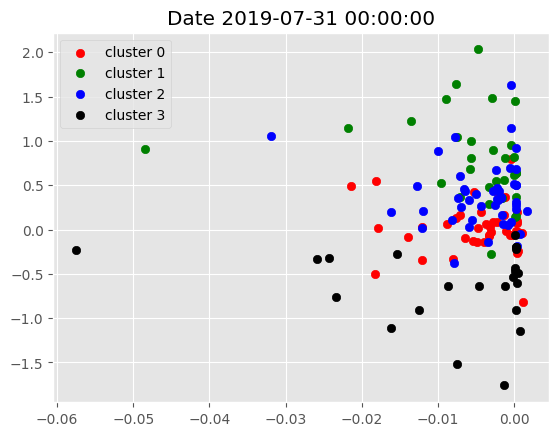

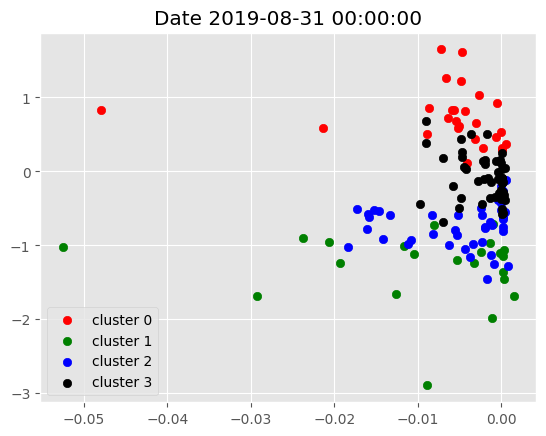

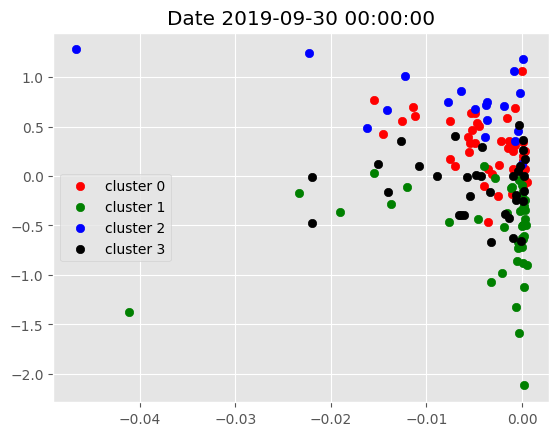

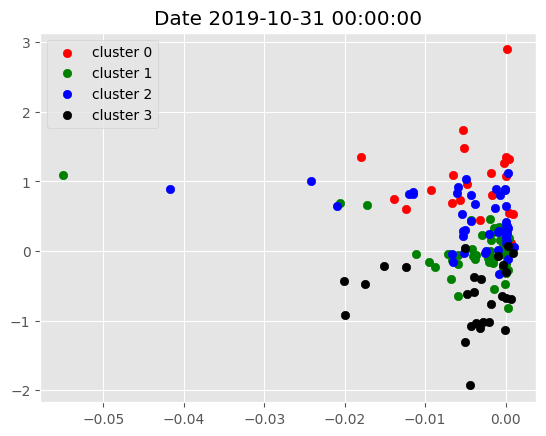

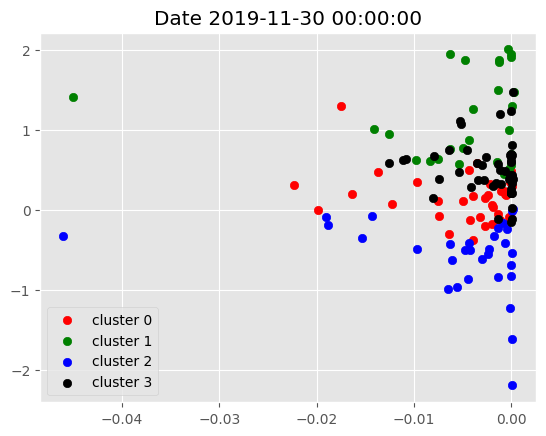

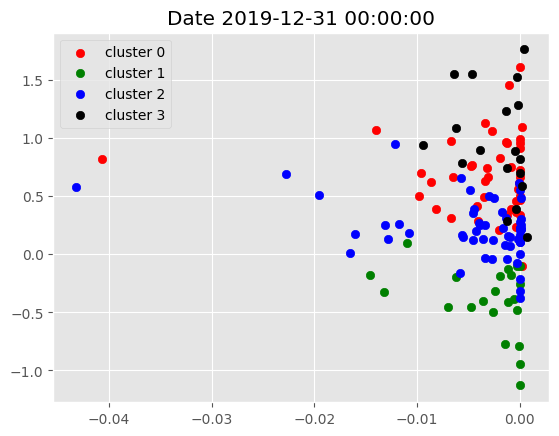

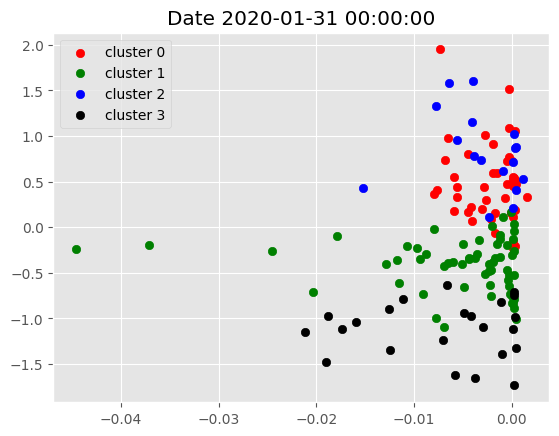

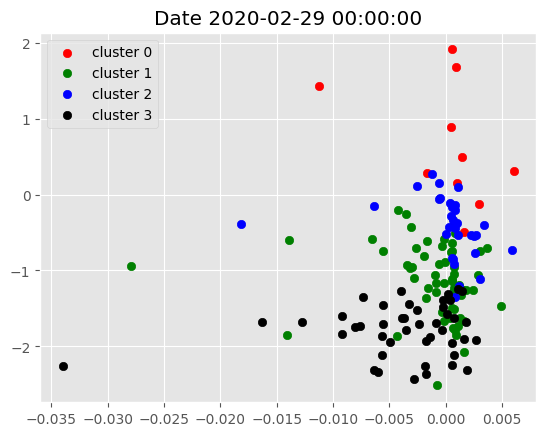

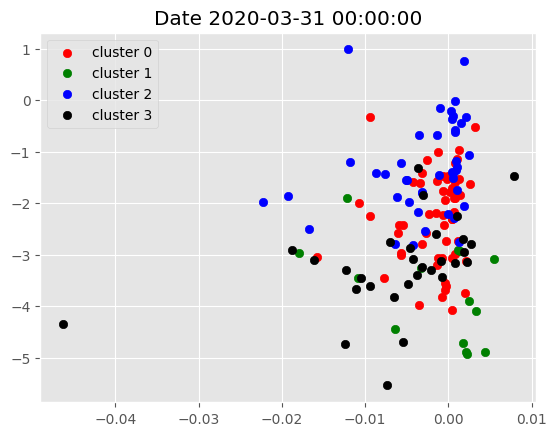

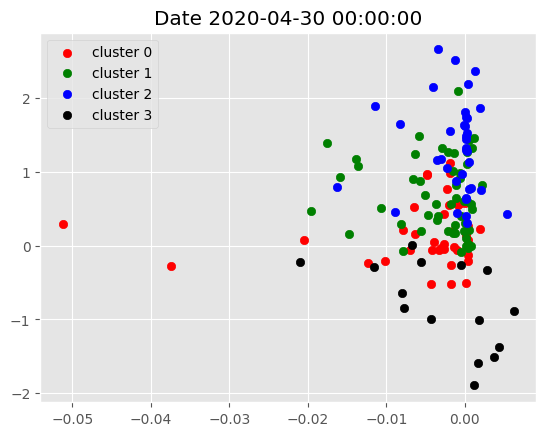

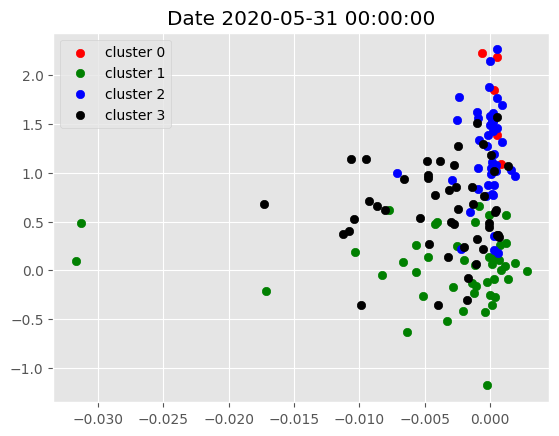

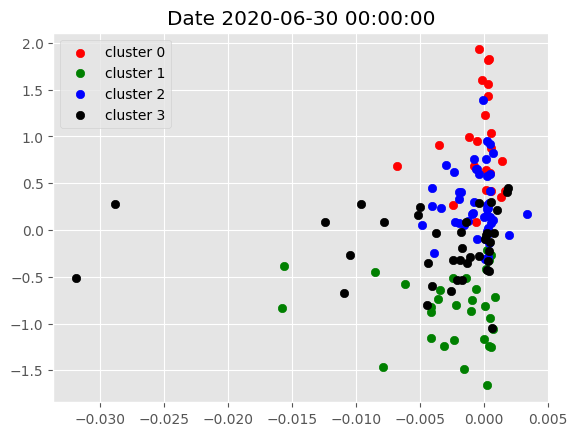

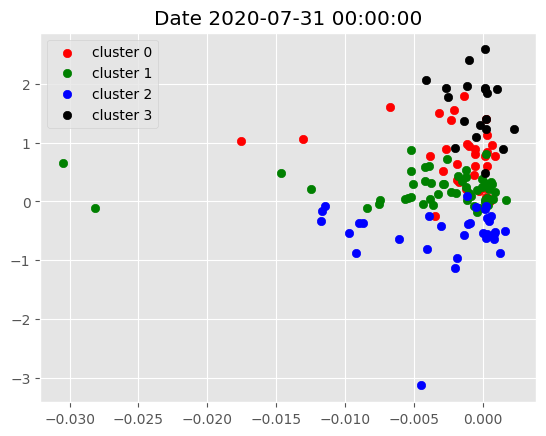

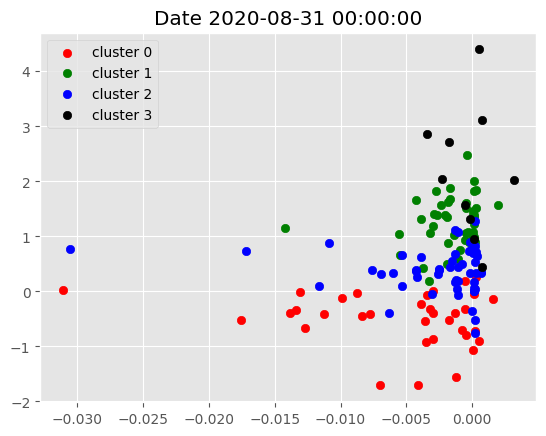

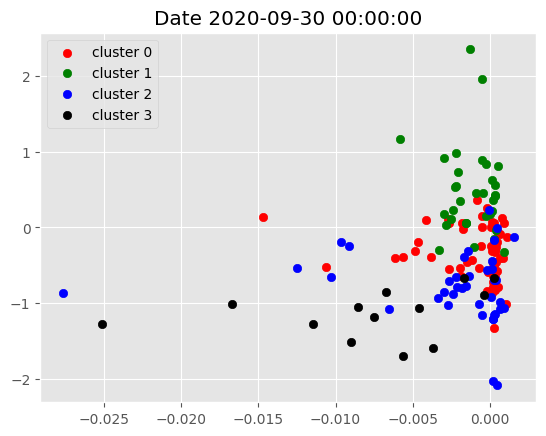

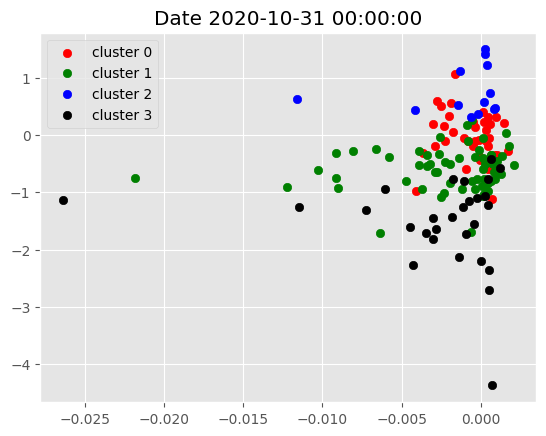

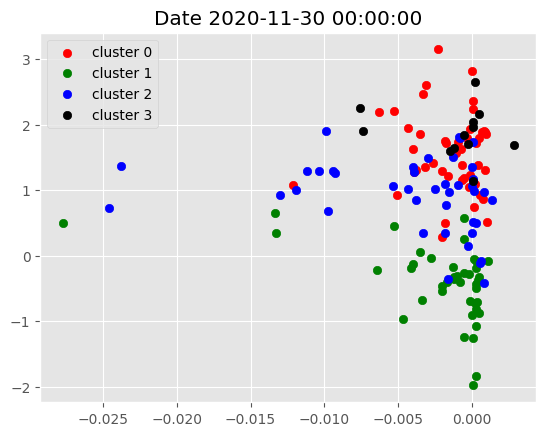

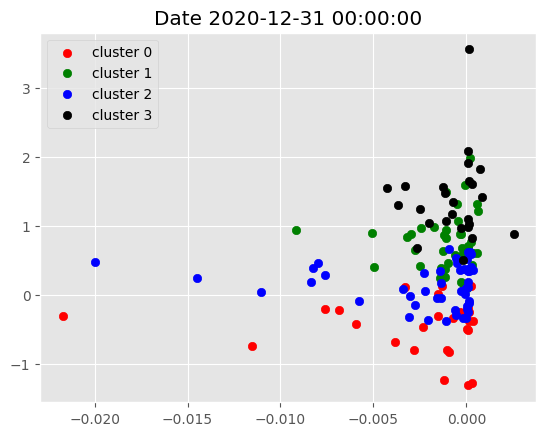

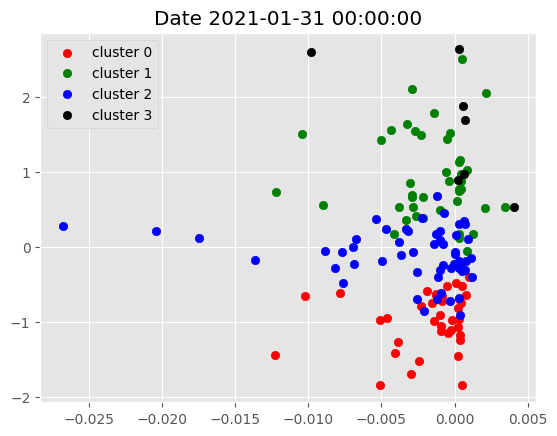

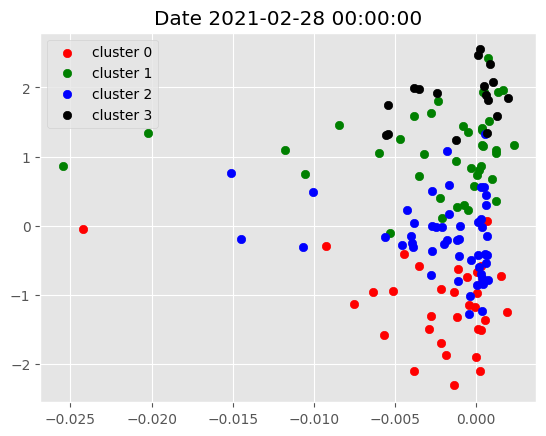

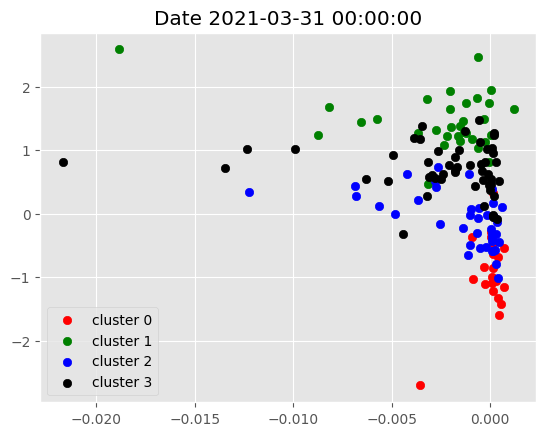

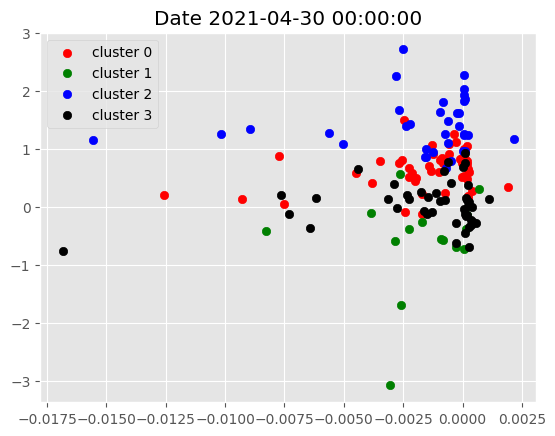

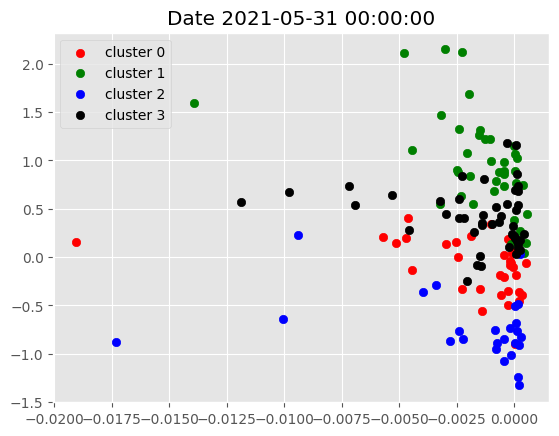

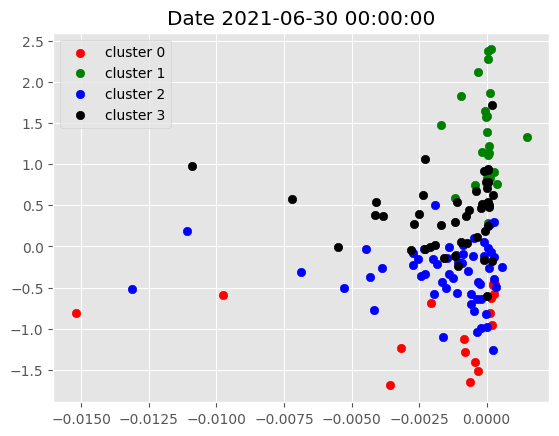

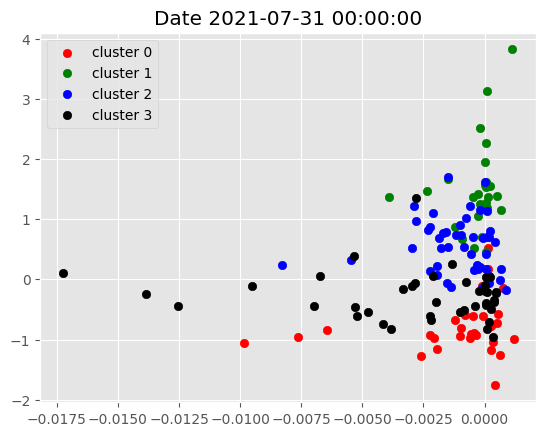

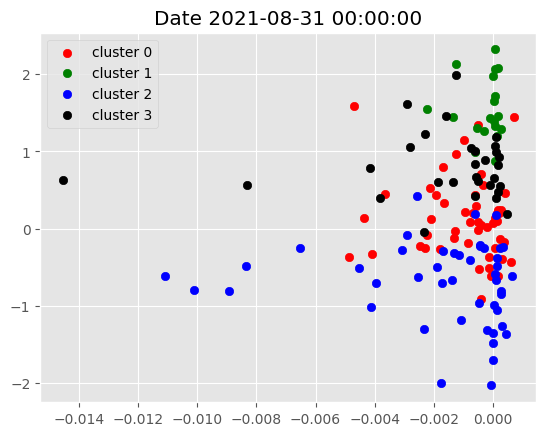

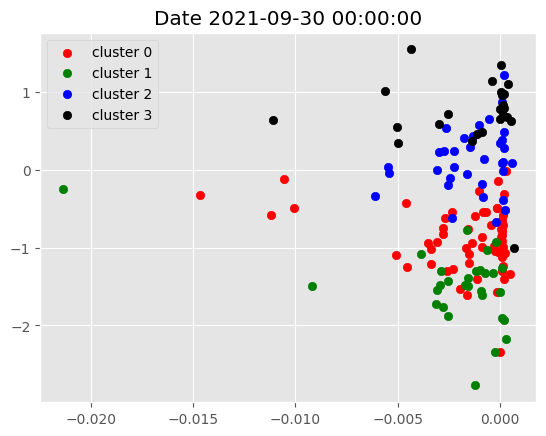

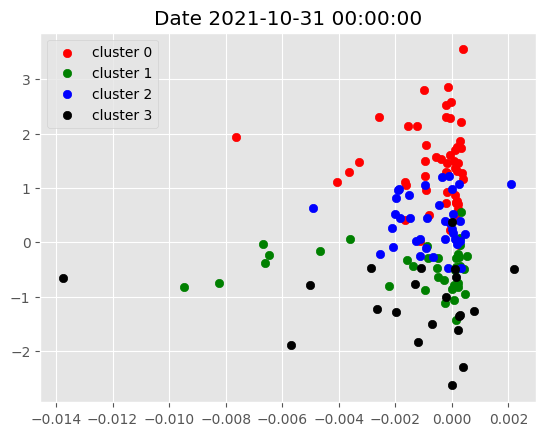

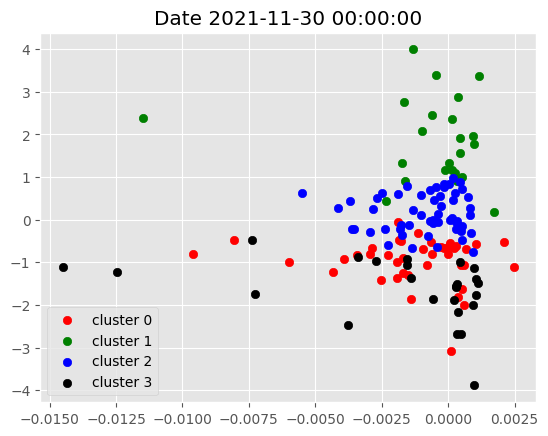

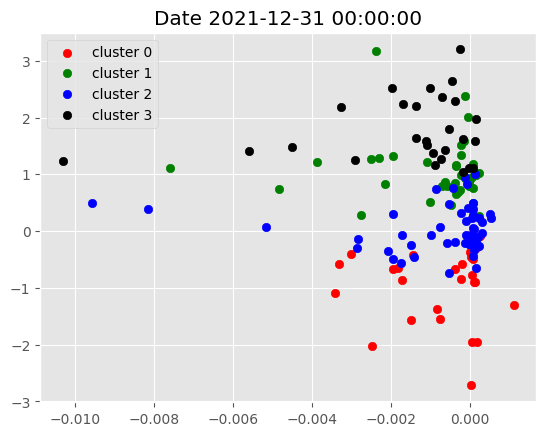

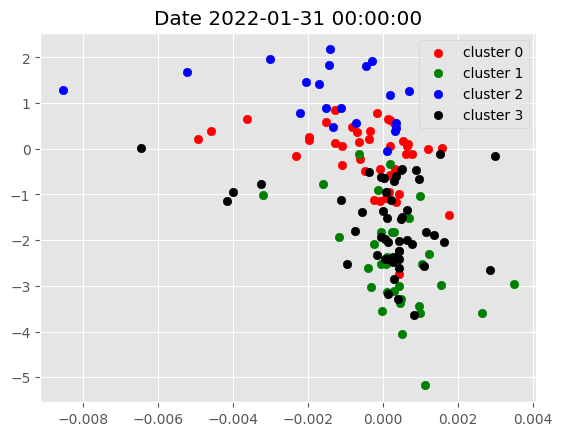

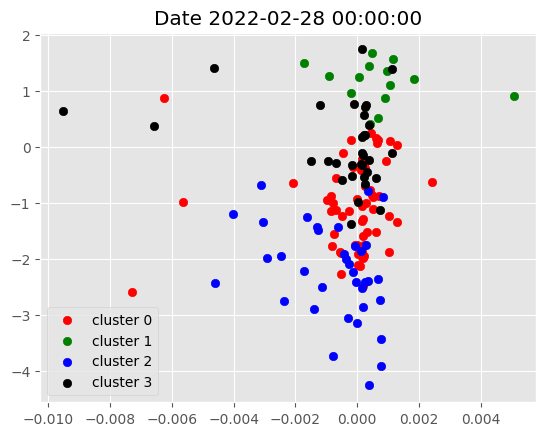

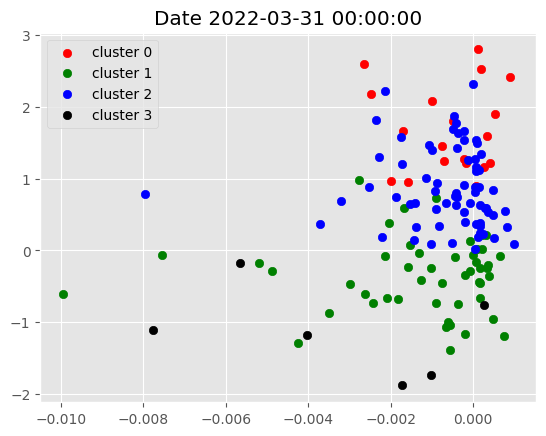

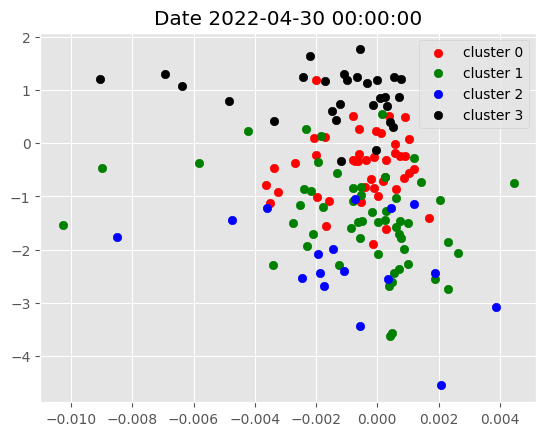

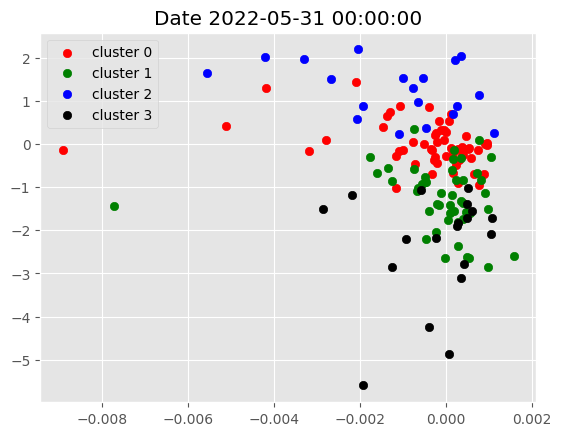

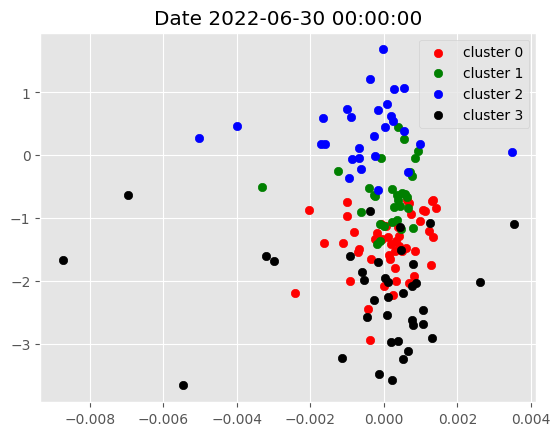

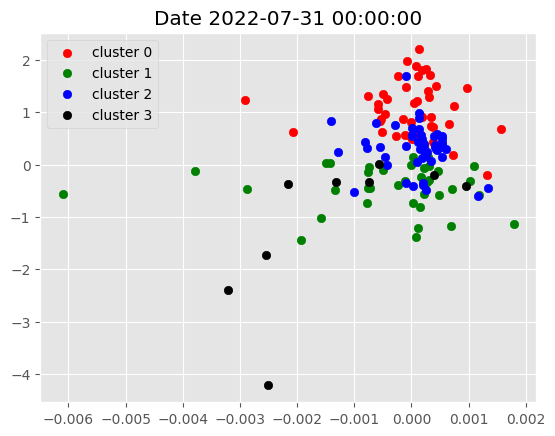

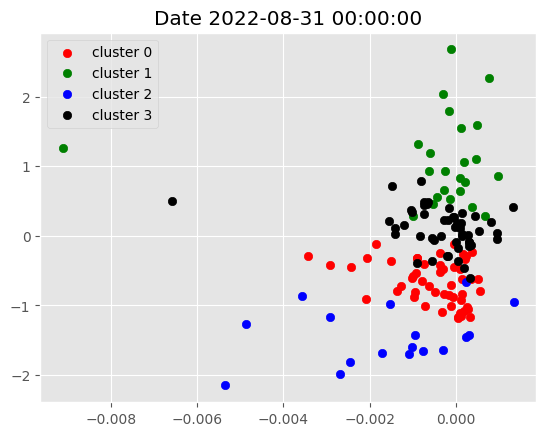

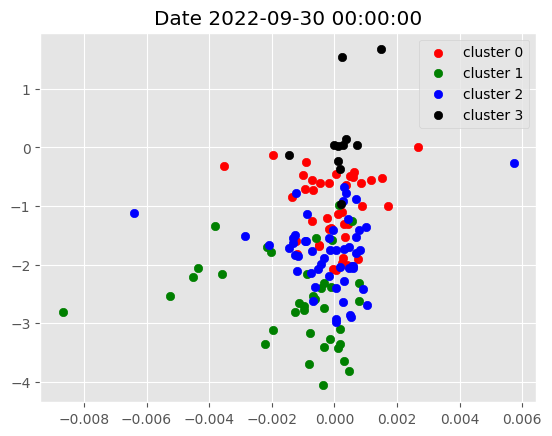

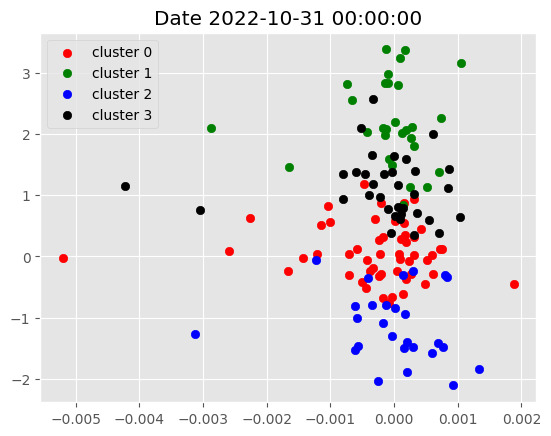

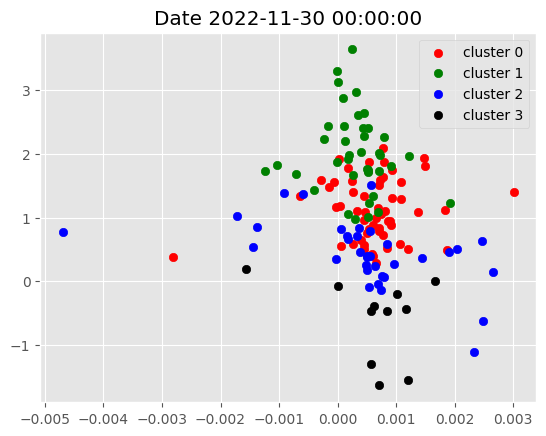

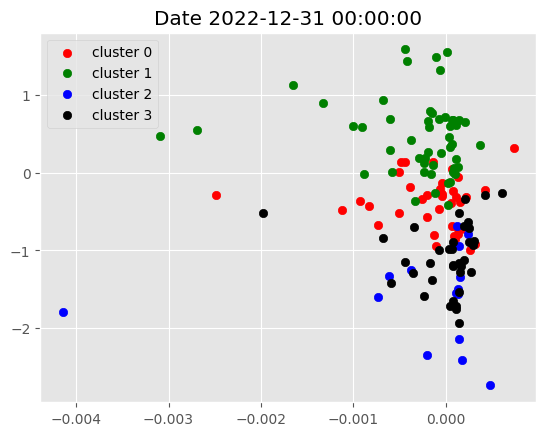

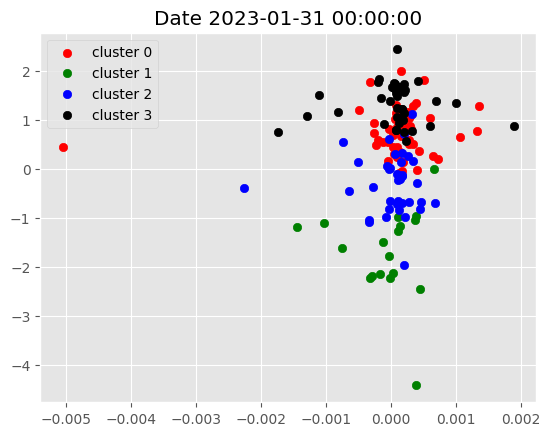

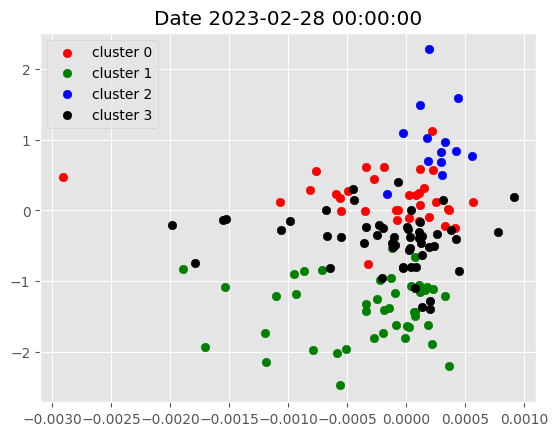

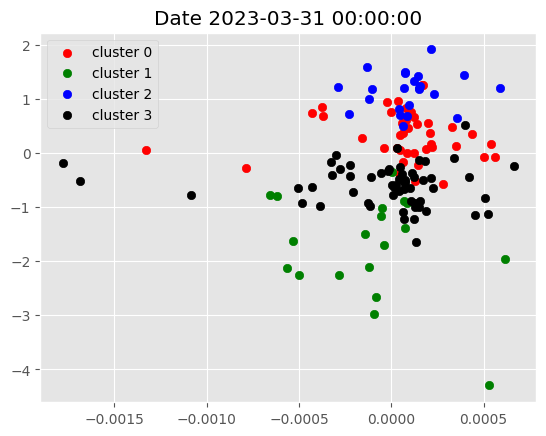

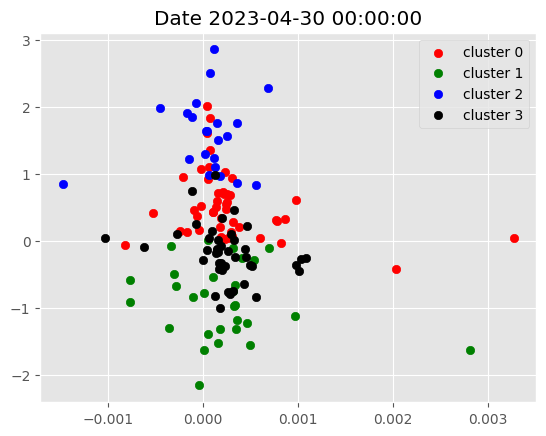

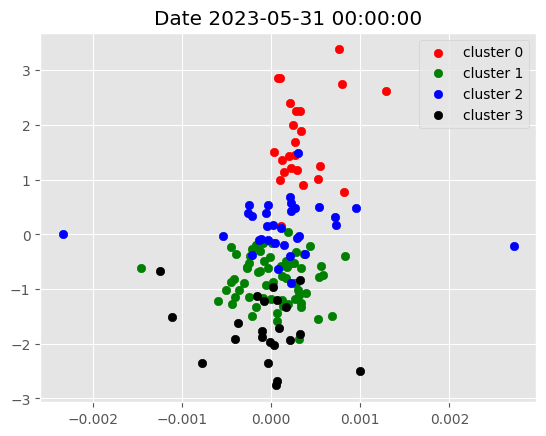

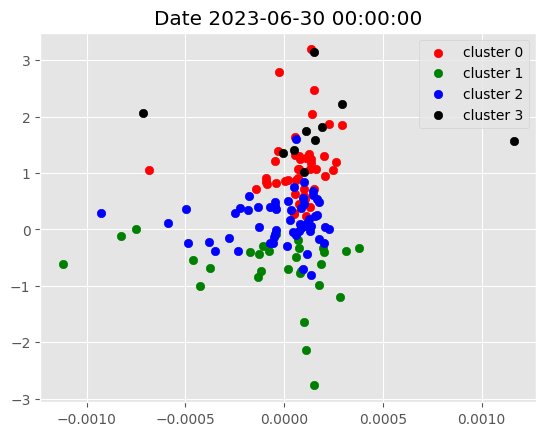

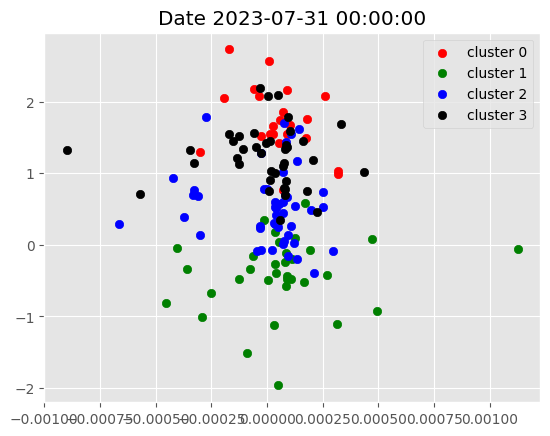

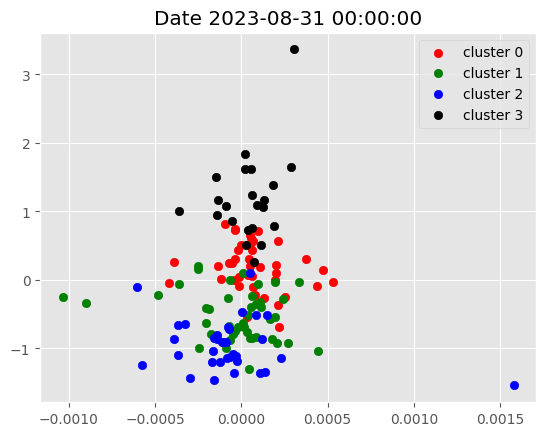

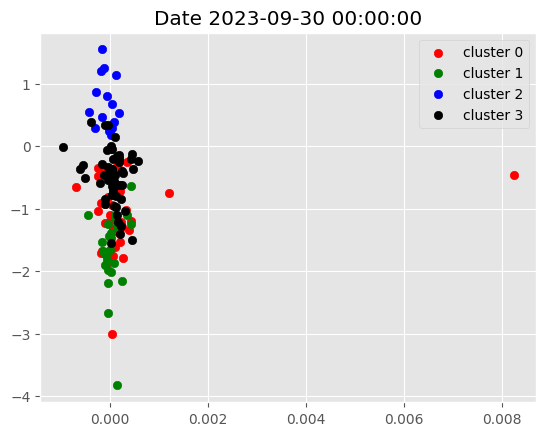

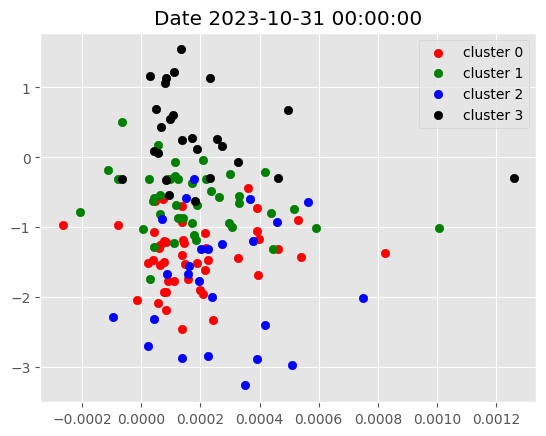

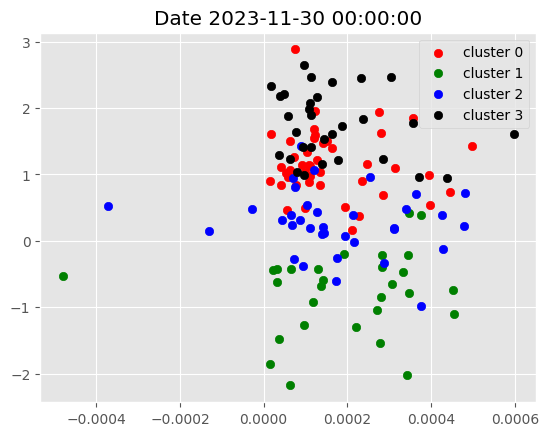

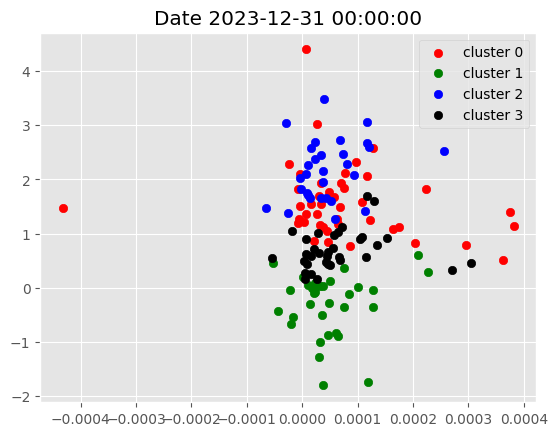

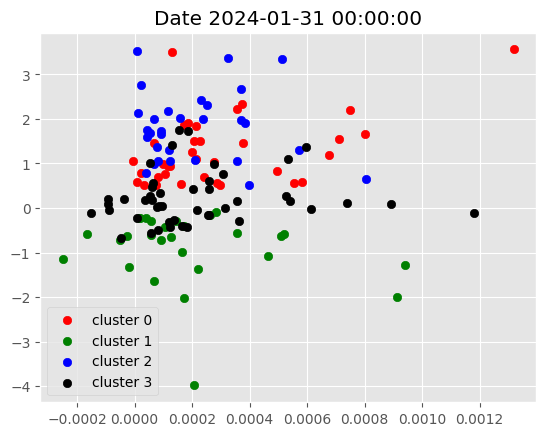

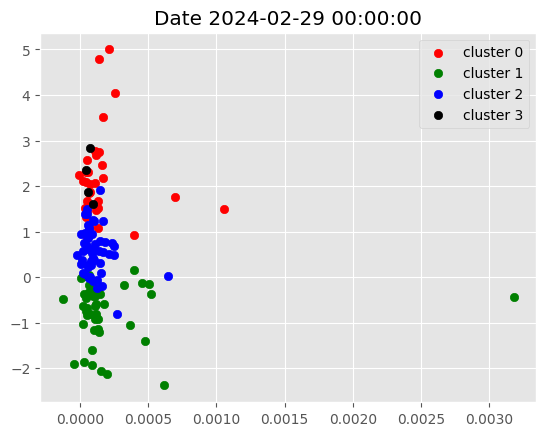

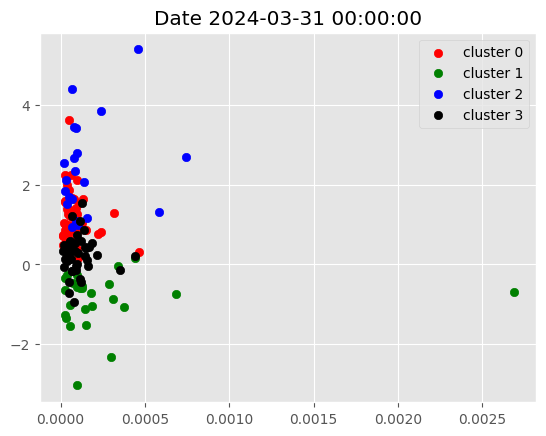

In [85]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)